# Apply resize convolutional layers to super-resolution

In [239]:
# Customize here. ## you should see this line if allow customizing

# ------------------------------------
# print("This is the area you can customize.")
# ------------------------------------

### Python package inspection

In [240]:
# Customize here.

# ------------------------------------
SKIP_INSTALL = True
# ------------------------------------

# install all packages we need here if you miss.

if not SKIP_INSTALL:
    !pip install chainer
    !pip install tensorflow
    !pip install opencv-python
    !pip install opencv-python-headless
    !pip install tqdm

In [241]:
# All necessay packages we should import

import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from chainer import Chain
from chainer import functions as F
from chainer import links as L
from keras import layers

from psutil import virtual_memory

### Memory availability check

In [242]:
# Check Whether you are using high-RAM.
# High-RAM Recommended.

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


### Data storage and migration

In [243]:
# Customize here.

# ------------------------------------
# If you are using colab, set it to true and also upload the source code to /ADV_CV_Code.
# Otherwise, set it to false. We will use/save the models in ./Model/ folder.
COLAB_SPACE   = True
# ------------------------------------

In [244]:
# if is colab space, copy the dataset from Google Drive to Colab local machine.
# Otherwise, use dataset in "Dataset/Raw Data/"

if COLAB_SPACE:
    from google.colab import drive
    drive.mount('/content/drive')

    parents_loc = "/content/drive/MyDrive/ADV_CV_Code/"
    native_loc = "/content/native/"
    data_loc = native_loc + 'Dataset/Raw Data/'

    # if native_loc exists, then we are running on a local machine
    if os.path.exists(native_loc):
        print("Native location exists")
    else:
        # create native_loc
        os.mkdir(native_loc)
        # copy all files from parents_loc to native_loc
        !cp -r $parents_loc* $native_loc
        print("Copied files from parents_loc to native_loc")
else:
    parents_loc = ''
    data_loc = 'Dataset/Raw Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Native location exists


### Data import

In [245]:
# Customize here.

# ------------------------------------
# defining the size of the image
SIZE = 256

path = data_loc + 'high_res'
path_low = data_loc + 'low_res'
# ------------------------------------

In [246]:
# initializing the arrays for the images.
high_img = []
low_img  = []

# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

files = os.listdir(path)
files = sorted_alphanumeric(files)

files_low = os.listdir(path_low)
files_low = sorted_alphanumeric(files_low)

# Scan all files in high_res folder. Only if both the high-res image and low-res image exist, append to Array.
# We fix the bug here. In the past, low resolution and high resolution were read separately.
# If any image file is missing, all subsequent images will be misaligned.
for i in tqdm(files):
    if i == '855.jpg':
        break
    elif i in files_low:
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

        img = cv2.imread(path_low + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:05<00:00, 161.78it/s]


### Visualization of dataset

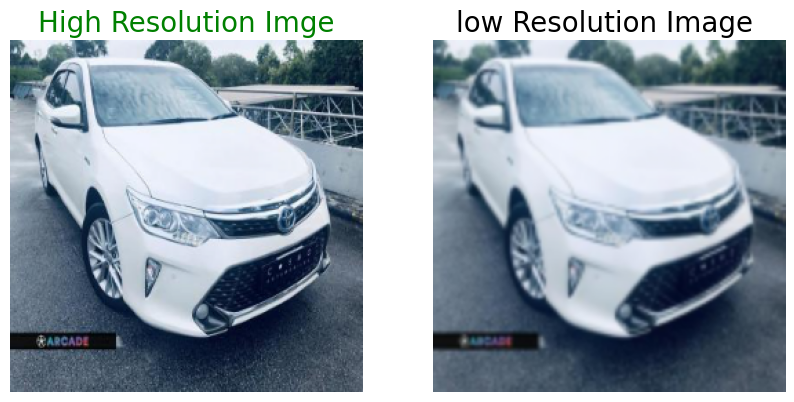

In [247]:
# Customize here.

# ------------------------------------
visualize_times = 1
visualize_ramdom = True
# ------------------------------------

# Visualize the image we read.
for i in range(visualize_times):
    if(visualize_ramdom):
        a = np.random.randint(0,855)
    else:
        a = i
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

### Train, Validation, Test Data Split

In [248]:
# Train, Test, Valid split, 700, 25, 130.

train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


### Model and Layers

In [249]:
# Customize here.

# ------------------------------------
# If set to true, we will always use the new layer structure.
# We have disabled this feature because we have found that the new layer structure is not always as good as the old one.
# Keep balance between the two structures. We may enable some of them only.
FORCE_UPGRADE = True

# If set to true, we will train the model forcibly.
# If set to false, we will load the model from the disk if it exists.
NEED_FITTING  = True

# Should set the model name here.
# MODEL_NAME    = 'final_model' # Without Resize Convolution Layer.
MODEL_NAME    = 'final_model_resize_0-2-bilinear' # With Resize Convolution Layer.
# ------------------------------------

if MODEL_NAME == "" or MODEL_NAME == "final_model":
    MODEL_PATH = parents_loc + "Model/final_model.h5"
else:
    MODEL_PATH = parents_loc + "Model/" + MODEL_NAME +".h5"

In [250]:
# Customize here.

# Our new functions. Resize Convolutional layer.
# 3 kinds of Resize Convolutional layer.
# You may try both of them.
# Or change the parameters of them. e.g. interpolation method, size of upsampling, etc.

def up_resize_conv(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()

    # Method 1: Resize 2x2 twice, then Conv2D with stride = 2.
    # Choose nearest interpolation method.

    # ------------------------------------
    # upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    # upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))

    # Method 2: Resize 4x4 once, then Conv2D with stride = 2.
    # Choose nearest interpolation method.
    # upsample.add(layers.UpSampling2D(size=(4, 4), data_format=None, interpolation='nearest'))
    # ------------------------------------

    # Method 3: Resize 4x4 once, then Conv2D with stride = 2.
    # Choose bicubic interpolation method.
    # upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear'))
    # upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear'))
    # upsample.add(layers.UpSampling2D(size=(4, 4), data_format=None, interpolation='bicubic'))
    # ------------------------------------

    # Method 4: Resize 4x4 once, then Conv2D with stride = 2.
    # Choose bilinear interpolation method.
    upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear'))
    upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear'))
    # upsample.add(layers.UpSampling2D(size=(4, 4), data_format=None, interpolation='bilinear'))
    # ------------------------------------

    upsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    # ------------------------------------

    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [251]:
# default functions of Layer.
# Down is convolutional layer with stride = 2
# Up is transposed convolutional layer with stride = 2.
# We focus on Up / Transposed convolutional / Deconvolutional layer / Resize convolutional in our project.
# Try to replace Deconvolutional layer with UpSampling2D layer Plus Conv2D layer.
# UpSampling2D layer Plus Conv2D layer, we call it Resize Convolutional layer.

def down_default(filters , kernel_size, apply_batch_normalization = True):
    # Unchanged.
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up_default(filters, kernel_size, dropout = False):
    # Unchanged.
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def down_upgrade(filters , kernel_size, apply_batch_normalization = True):
    # Unchanged.
    return down_default(filters , kernel_size, apply_batch_normalization)

In [252]:
# Interface For model, with type = "upgrade" or "resize_conv", we will use new layer structure.
# Otherwise, we will use the old one.

def upgrade(type = ""):
    # upsample = tf.keras.models.Sequential()
    # if type == "upgrade" or FORCE_UPGRADE:
    #     pass
    # else:
    #     pass
    return tf.keras.models.Sequential()

# Use different layer structure according to the type.
def up(filters, kernel_size, dropout = False, type = ''):
    if type == 'resize_conv' or FORCE_UPGRADE:
        return up_resize_conv(filters, kernel_size, dropout)
    else:
        return up_default(filters, kernel_size, dropout)

def down(filters , kernel_size, apply_batch_normalization = True, type = ""):
    if type == "upgrade" or FORCE_UPGRADE:
        return down_upgrade(filters , kernel_size, apply_batch_normalization)
    else:
        return down_default(filters , kernel_size, apply_batch_normalization)

In [253]:
# Customize here.

# You could change the model structure here.
# Many things to do.
# You may not change all deconvolutional layers to resize convolutional layers.
# You may add more deconvolutional layers / resize convolutional layers.
# You may change some parameters of the layers.

# Once you change the model structure, you should change the model name.

# ------------------------------------
def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    # convolutions down the stack
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)

    # deconvolutions up the stack OR first upsampling then convolutions
    u1 = up(512,(3,3),False, "")(d5)
    d4_ = upgrade()(d4)
    # Residual connection
    u1 = layers.concatenate([u1,d4_])
    # deconvolutions up the stack OR first upsampling then convolutions
    u2 = up(256,(3,3),False, "")(u1)
    d3_ = upgrade()(d3)
    # Residual connection
    u2 = layers.concatenate([u2,d3_])
    # deconvolutions up the stack OR first upsampling then convolutions
    u3 = up(128,(3,3),False, "")(u2)
    d2_ = upgrade()(d2)
    # Residual connection
    u3 = layers.concatenate([u3,d2_])
    # deconvolutions up the stack OR first upsampling then convolutions
    u4 = up(128,(3,3),False, "resize_conv")(u3)
    d1_ = upgrade()(d1)
    # Residual connection
    u4 = layers.concatenate([u4,d1_])
    # deconvolutions up the stack OR first upsampling then convolutions
    u5 = up(3,(3,3),False, "resize_conv")(u4)
    inputs_ = upgrade()(inputs)
    # Residual connection
    u5 = layers.concatenate([u5,inputs_])
    # output layer
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)
# ------------------------------------

### Training / Loading Model

In [254]:
# Customize here.
# ------------------------------------
# learning rate
lr = 0.001
# loss function
loss_method = 'mean_absolute_error'
# epochs, In Resize Convolutional layer, epoch > 7 may lead to unstable results.
epoch_num = 9
# batch size
batch_count = 1
# metrics
metrics_choice = ['acc']
# ------------------------------------

In [255]:
if NEED_FITTING or not os.path.exists(MODEL_PATH):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    model = model()

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = loss_method,
                metrics = metrics_choice)
    # Will show Quantity Evaluation during training.
    model.fit(train_low_image, train_high_image, epochs = epoch_num, batch_size = batch_count,
          validation_data = (validation_low_image,validation_high_image), callbacks=[callback])

    # if not os.path.exists(MODEL_PATH):
    model.save(MODEL_PATH)
else:
    print("Load From Dir.")
    model = tf.keras.models.load_model(MODEL_PATH)

print("Model Name:", MODEL_NAME)

Epoch 1/9
700/700 [==============================] - 27s 33ms/step - loss: 0.0750 - acc: 0.6341 - val_loss: 0.0360 - val_acc: 0.6638
Epoch 2/9
700/700 [==============================] - 23s 32ms/step - loss: 0.0331 - acc: 0.7612 - val_loss: 0.0298 - val_acc: 0.7362
Epoch 3/9
700/700 [==============================] - 23s 32ms/step - loss: 0.0284 - acc: 0.7957 - val_loss: 0.0280 - val_acc: 0.8034
Epoch 4/9
700/700 [==============================] - 23s 32ms/step - loss: 0.0260 - acc: 0.8070 - val_loss: 0.0268 - val_acc: 0.8673
Epoch 5/9
700/700 [==============================] - 22s 32ms/step - loss: 0.0253 - acc: 0.8186 - val_loss: 0.0267 - val_acc: 0.7871
Epoch 6/9
700/700 [==============================] - 22s 32ms/step - loss: 0.0246 - acc: 0.8133 - val_loss: 0.0242 - val_acc: 0.8845
Epoch 7/9
700/700 [==============================] - 23s 32ms/step - loss: 5.9979 - acc: 0.8059 - val_loss: 6394.7856 - val_acc: 0.3921
Model Name: final_model_resize_0-2-bilinear


### Prediction Visualization and Evaluation (Qualitative Method)

1/1 [==============================] - 0s 195ms/step


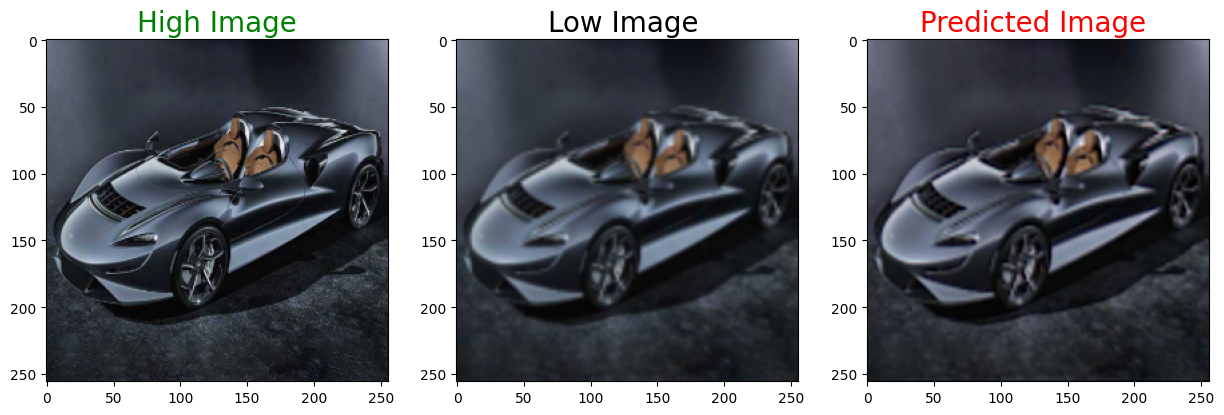

1/1 [==============================] - 0s 27ms/step


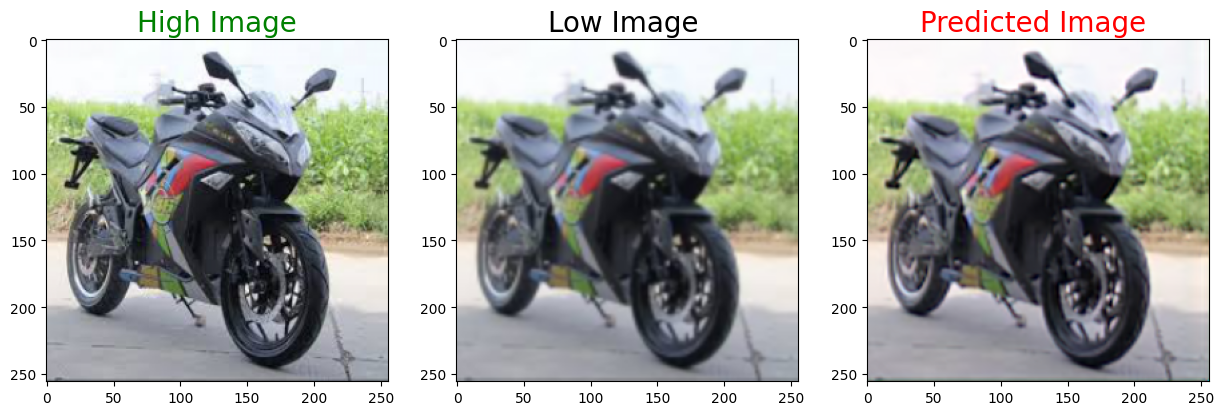

In [256]:
# Customize here.
# ------------------------------------
visualize_times_pr = 2 # Max 25.
visualize_ramdom_pr = True
# ------------------------------------

def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

# Visualize the predicted image.
for a in range(visualize_times_pr):
    if(visualize_ramdom_pr):
        i = np.random.randint(0,25)
    else:
        i = a
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

### Model Structure Visualization

In [257]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_135 (Sequential  (None, 128, 128, 128)        3584      ['input_10[0][0]']            
 )                                                                                                
                                                                                                  
 sequential_136 (Sequential  (None, 64, 64, 128)          147584    ['sequential_135[0][0]']      
 )                                                                                                
                                                                                            

### Model Evaluation (Quantitative Method) Failed!

In [258]:
# Try to use quantitive evaluation for testing data, but we failed.

# y_pred = []
# y_true = []

# for i in range(len(test_high_image)):
#     predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
#     y_pred.append(predicted)
#     y_true.append(test_high_image[i])

# y_pred = np.array(y_pred)
# y_true = np.array(y_true)

# y_pred = y_pred.reshape(y_pred.shape[0],-1)
# y_true = y_true.reshape(y_true.shape[0],-1)

# def calculate_results(y_true, y_pred):
#     y_pred_thresholded = y_pred > 0.5
#     true_positives = np.sum(y_true * y_pred_thresholded)



# loss, accuracy, f1_score, precision, recall = calculate_results(y_true, y_pred)
# print(f'Loss: {loss}')
# print(f'Accuracy: {accuracy}')
# print(f'F1 Score: {f1_score}')
# print(f'Precision: {precision}')

In [259]:
print("The End")

The End
